In [1]:
import os, cv2, random
import numpy as np
import sys, time
from IPython.core.display import clear_output
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR_DOG = 'data/train/dogs/'
TRAIN_DIR_CAT = 'data/train/cats/'
TEST_DIR = 'data/test/'

In [3]:
ROWS = 256
COLS = 256
ROWS2 = 64
COLS2 = 64
CHANNELS = 3

In [4]:
train_dogs =   [TRAIN_DIR_DOG+i for i in os.listdir(TRAIN_DIR_DOG) if 'dog' in i]
train_cats =   [TRAIN_DIR_CAT+i for i in os.listdir(TRAIN_DIR_CAT) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [5]:
train_images = train_dogs + train_cats
random.shuffle(train_images)
random.shuffle(test_images)
test2_images = test_images[0:20]

In [6]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS2, COLS2), interpolation=cv2.INTER_CUBIC)

def read_image2(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [7]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS2, COLS2), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%1000 == 0: 

            print('Processed {} of {}'.format(i, count))
    
    return data

def prep_data2(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image2(image_file)
        data[i] = image.T
        if i%2 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [8]:
train = prep_data(train_images)
test = prep_data(test_images)
test2 = prep_data2(test2_images)

Processed 0 of 8000
Processed 1000 of 8000
Processed 2000 of 8000
Processed 3000 of 8000
Processed 4000 of 8000
Processed 5000 of 8000
Processed 6000 of 8000
Processed 7000 of 8000
Processed 0 of 1800
Processed 1000 of 1800
Processed 0 of 20
Processed 2 of 20
Processed 4 of 20
Processed 6 of 20
Processed 8 of 20
Processed 10 of 20
Processed 12 of 20
Processed 14 of 20
Processed 16 of 20
Processed 18 of 20


In [9]:
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))
print("Test shape: {}".format(test2.shape))

Train shape: (8000, 3, 64, 64)
Test shape: (1800, 3, 64, 64)
Test shape: (20, 3, 256, 256)


In [10]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)


In [11]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

Using TensorFlow backend.


In [12]:
def catdog():
    
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=train.shape[1:], activation='relu'))
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

In [13]:
model = catdog()

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 64, 32)         18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 64, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 32, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 32, 64)         9280      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 32, 64)         36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 16, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 16, 128)        36992     
__________

In [15]:
epochs = 50
batch_size = 50

In [17]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto') 

In [18]:
def run_catdog():
    
    history = LossHistory()
    print("running model...")
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
            validation_split=0.25, verbose=2, shuffle=True, callbacks=[history, early_stopping])
            #validation_split=0.25, verbose=2, shuffle=True, callbacks=[history])
    
    print("making predictions on test set...")
    predictions = model.predict(test, verbose=0)
    return predictions, history

In [19]:
predictions, history = run_catdog()

loss = history.losses
val_loss = history.val_losses

running model...
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
 - 7s - loss: 0.7591 - acc: 0.5022 - val_loss: 0.6912 - val_acc: 0.5390
Epoch 2/50
 - 2s - loss: 0.6936 - acc: 0.5218 - val_loss: 0.6799 - val_acc: 0.5835
Epoch 3/50
 - 2s - loss: 0.6749 - acc: 0.5700 - val_loss: 0.6660 - val_acc: 0.5925
Epoch 4/50
 - 2s - loss: 0.6560 - acc: 0.6168 - val_loss: 0.7281 - val_acc: 0.5460
Epoch 5/50
 - 2s - loss: 0.6416 - acc: 0.6260 - val_loss: 0.6219 - val_acc: 0.6410
Epoch 6/50
 - 2s - loss: 0.6243 - acc: 0.6638 - val_loss: 0.6300 - val_acc: 0.6330
Epoch 7/50
 - 2s - loss: 0.6064 - acc: 0.6738 - val_loss: 0.6271 - val_acc: 0.6385
Epoch 8/50
 - 2s - loss: 0.5892 - acc: 0.6903 - val_loss: 0.6322 - val_acc: 0.6300
Epoch 00008: early stopping
making predictions on test set...


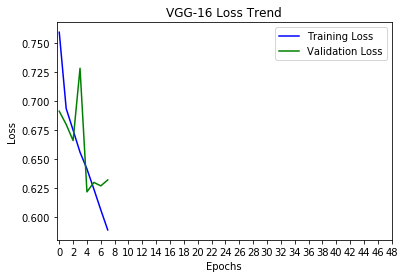

In [20]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

I am 40.26% sure this is a Cat


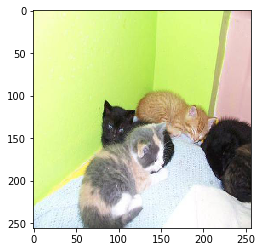

I am 37.61% sure this is a Cat


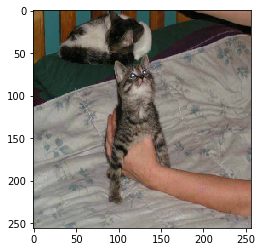

I am 44.93% sure this is a Cat


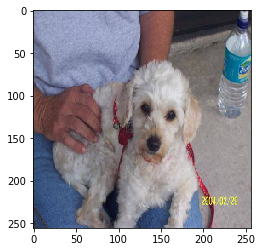

I am 65.86% sure this is a Cat


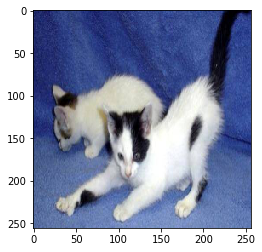

I am 81.53% sure this is a Dog


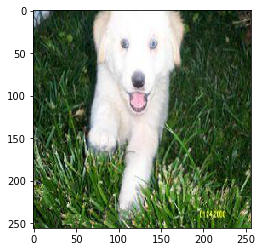

I am 93.08% sure this is a Cat


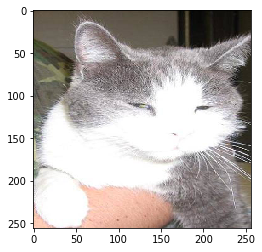

I am 85.86% sure this is a Dog


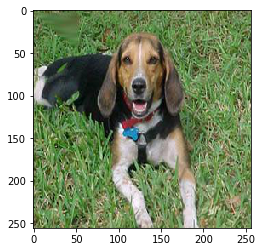

I am 74.88% sure this is a Cat


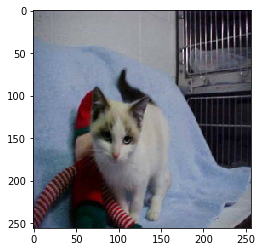

I am 78.59% sure this is a Dog


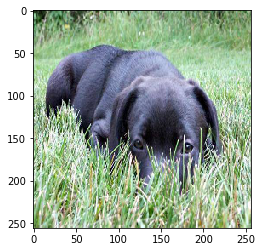

I am 55.86% sure this is a Cat


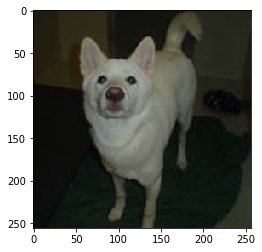

I am 84.95% sure this is a Cat


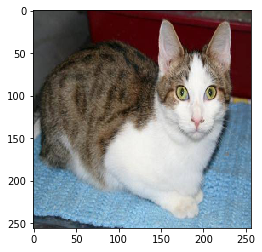

I am 56.81% sure this is a Cat


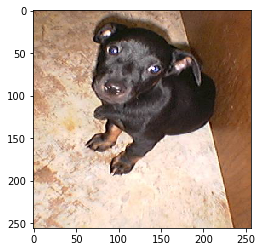

I am 55.82% sure this is a Cat


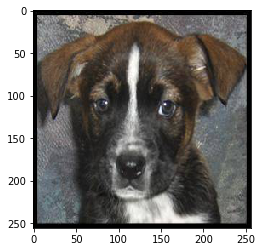

I am 57.83% sure this is a Cat


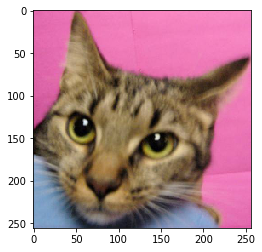

I am 72.55% sure this is a Cat


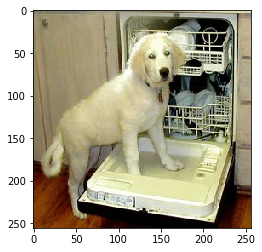

I am 46.68% sure this is a Cat


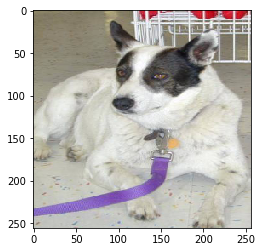

I am 84.13% sure this is a Cat


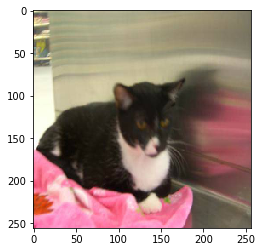

I am 56.91% sure this is a Cat


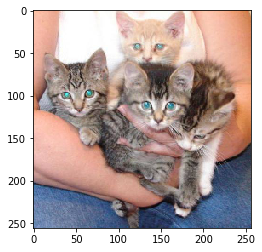

I am 64.24% sure this is a Cat


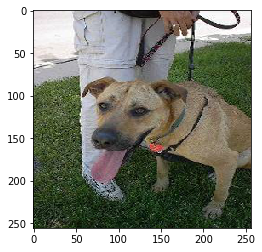

I am 58.85% sure this is a Cat


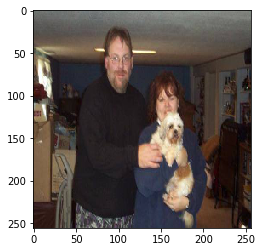

In [21]:
for i in range(0,20):
    if predictions[i, 0] >= 0.75: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test2[i].T)
    plt.show()